In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, make_scorer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import sklearn
import matplotlib.pyplot as plt
import numpy as np

# Carga de los datasets

In [ ]:
train = pd.read_csv('train_1.csv') #train = pd.read_csv('train_consolidado_completo.csv')
test = pd.read_csv('test_1.csv')   #test = pd.read_csv('test_consolidado_completo.csv')

In [ ]:
to_drop = ['id','fault_severity']
y = train['fault_severity']
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop[:1], inplace=True, axis=1)
X = train
X.shape

(7381, 84)

In [ ]:
scores_consolidado = {}
#scores_consolidado_complete = {}
print('Train: ', train.shape)
print('Test: ', test.shape)

Train:  (7381, 84)
Test:  (11171, 84)


## Primera Iteracion, dataset sin modificaciones

In [ ]:
models = {'RF': RandomForestClassifier(),
          'GBC': GradientBoostingClassifier(),
          'DT': DecisionTreeClassifier(),
          'KNN':KNeighborsClassifier()}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_test)
  loss = log_loss(y_test, y_pred)
  score = model.score(X_test, y_test)
  scores_consolidado['1_{}'.format(name)] = [['log_loss: ',loss],['score: ',score]]
  print('Model: {}   log_loss: {}'.format(name,loss))
  print('Model: {}   score: {}'.format(name,score))
  print('___'*20)

Model: RF   log_loss: 0.8315947745024285
Model: RF   score: 0.7051918735891648
____________________________________________________________
Model: GBC   log_loss: 0.5976638554985724
Model: GBC   score: 0.7187358916478556
____________________________________________________________
Model: DT   log_loss: 10.876911920615587
Model: DT   score: 0.6785553047404064
____________________________________________________________
Model: KNN   log_loss: 2.459482808226647
Model: KNN   score: 0.6397291196388262
____________________________________________________________


Observamos que en una primera aproximación sin modifica las feature o realizar seleccion de componentes principales los modelos con mejor performance son: Random Forest y Gradient Bossting Classifier, siendo este último el que obtuvo la menor perdida

# Segunda iteracion, rescanlando los datos

In [ ]:
X_Scaled = StandardScaler().fit_transform(train)
X_Scaled.shape
1338 - 1113

225

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y, test_size = 0.3, random_state = 1)
for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_test)
  loss = log_loss(y_test, y_pred)
  score = model.score(X_test, y_test)
  scores_consolidado['2_{}'.format(name)] = [['log_loss: ',loss],['score: ',score]]
  print('Model: {}   log_loss: {}'.format(name,loss))
  print('Model: {}   score: {}'.format(name,score))
  print('__'*20)

Model: RF   log_loss: 0.7614260921343133
Model: RF   score: 0.709255079006772
________________________________________
Model: GBC   log_loss: 0.5976547758516163
Model: GBC   score: 0.7182844243792325
________________________________________
Model: DT   log_loss: 10.798320418883904
Model: DT   score: 0.6808126410835215
________________________________________
Model: KNN   log_loss: 2.9901517056875164
Model: KNN   score: 0.6735891647855531
________________________________________


# Analizis de Features

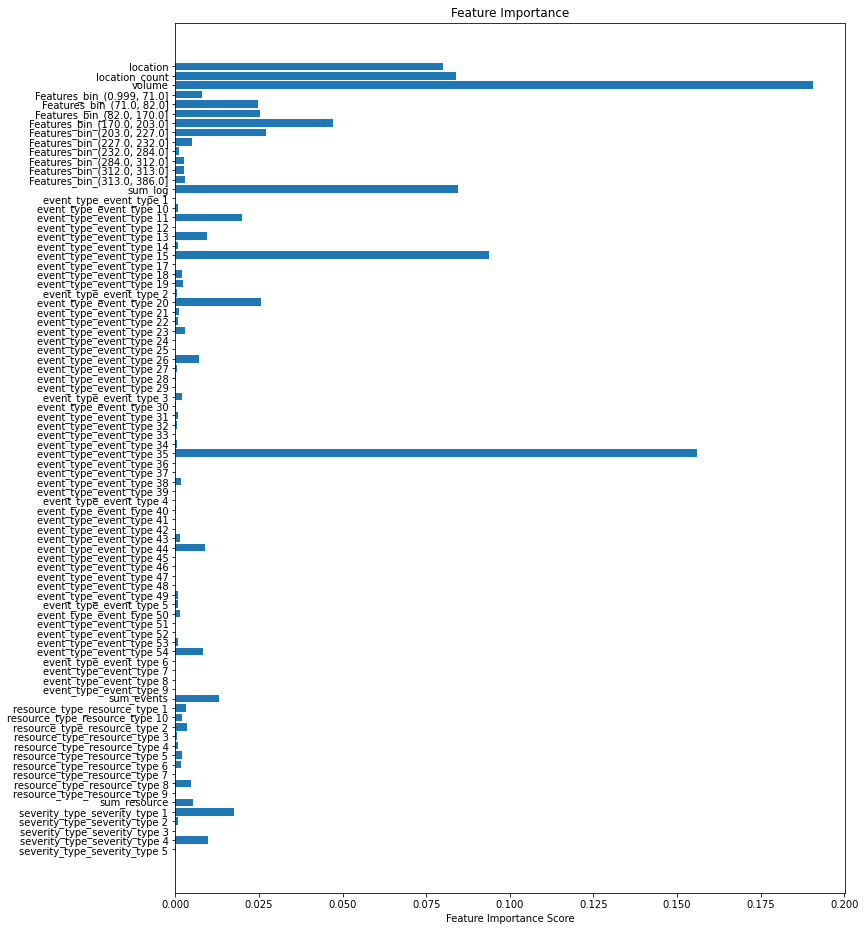

In [ ]:
plt.rcParams['figure.figsize'] = [12,16]
fig, ax = plt.subplots()

features = train.columns
y_pos = np.arange(len(features))
performance = models['GBC'].feature_importances_


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  
ax.set_xlabel('Feature Importance Score')
ax.set_title('Feature Importance')

plt.show()

In [ ]:
pd.Series(models['GBC'].feature_importances_).value_counts().sort_index()

0.000000    22
0.000019     1
0.000067     1
0.000071     1
0.000108     1
            ..
0.083752     1
0.084412     1
0.093652     1
0.156022     1
0.190701     1
Length: 63, dtype: int64

In [ ]:
#Training automatic selector
selector = SelectKBest(mutual_info_classif, k = 64)
selector.fit(X,y)
selector.scores_.shape

(84,)

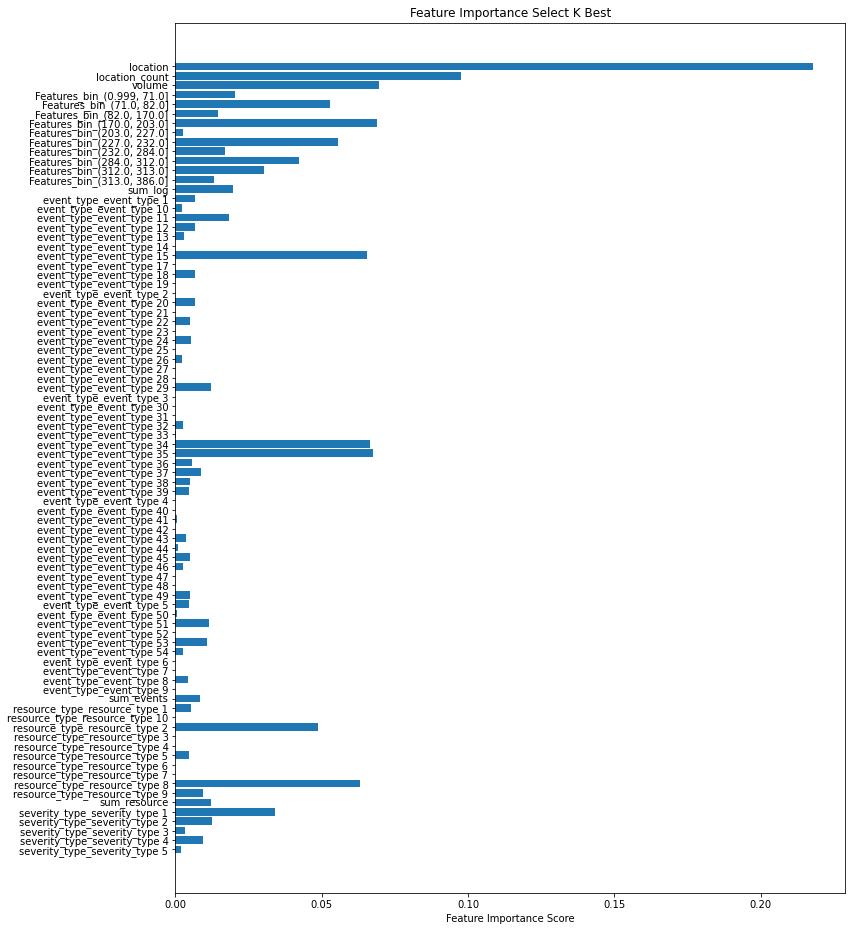

In [ ]:
plt.rcParams['figure.figsize'] = [12,16]
fig, ax = plt.subplots()

features = train.columns
y_pos = np.arange(len(features))
performance =  selector.scores_

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  
ax.set_xlabel('Feature Importance Score')
ax.set_title('Feature Importance Select K Best')

plt.show()

In [ ]:
selector_scores_features = pd.Series(selector.scores_)
GBC_scores_features = pd.Series(models['GBC'].feature_importances_)

In [ ]:
#Selector Features Select K Best
print(len(selector_scores_features[selector_scores_features == 0]))
selector_scores_features_zeros = selector_scores_features[selector_scores_features == 0].index
selector_scores_features[selector_scores_features == 0].index

25


Int64Index([21, 23, 24, 26, 28, 30, 32, 33, 35, 36, 37, 46, 47, 49, 54, 55, 60,
            63, 64, 66, 69, 71, 72, 74, 75],
           dtype='int64')

In [ ]:
# Features importance given by GBC Algortim
print(len(GBC_scores_features[GBC_scores_features == 0]))
GBC_scores_features_zeros = GBC_scores_features[GBC_scores_features == 0].index
GBC_scores_features[GBC_scores_features == 0].index

22


Int64Index([14, 17, 21, 29, 30, 39, 42, 43, 45, 46, 48, 49, 52, 54, 55, 59, 60,
            63, 64, 65, 66, 81],
           dtype='int64')

In [ ]:
pd.Series(GBC_scores_features_zeros.isin(selector_scores_features_zeros)).value_counts()

False    12
True     10
dtype: int64

# Tercer Iteracion, Seleccion automatica de features y rescalamiento de datos

In [ ]:
# Transform X and y with the best features
X_selected = selector.transform(X) 

In [ ]:
X_selected = StandardScaler().fit_transform(X_selected)
X_selected.shape

(7381, 64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.3, random_state = 1)
for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_test)
  loss = log_loss(y_test, y_pred)
  score = model.score(X_test, y_test)
  scores_consolidado['3_{}'.format(name)] = [['log_loss: ',loss],['score: ',score]]
  print('Model: {}   log_loss: {}'.format(name,loss))
  print('Model: {}   score: {}'.format(name,score))
  print('__'*20)

Model: RF   log_loss: 0.7117107542202854
Model: RF   score: 0.7033860045146727
________________________________________
Model: GBC   log_loss: 0.5975829761383757
Model: GBC   score: 0.7200902934537246
________________________________________
Model: DT   log_loss: 10.844786866741318
Model: DT   score: 0.6799097065462754
________________________________________
Model: KNN   log_loss: 2.9273783436843583
Model: KNN   score: 0.6762979683972912
________________________________________


# Analizando Rendimientos

In [ ]:
Scores_consolidado_completo = pd.DataFrame(scores_consolidado_complete)

,1_RF,1_GBC,1_DT,1_KNN,2_RF,2_GBC,2_DT,2_KNN,3_RF,3_GBC,3_DT,3_KNN
0,"[log_loss: , 0.7773097029386979]","[log_loss: , 0.6014685591010664]","[log_loss: , 10.45302791595496]","[log_loss: , 3.2528706423152567]","[log_loss: , 0.7963529281606756]","[log_loss: , 0.6004046148431805]","[log_loss: , 10.530680617893557]","[log_loss: , 3.202871347545518]","[log_loss: , 0.8894057624178895]","[log_loss: , 0.5947427791669142]","[log_loss: , 10.139964328992878]","[log_loss: , 2.6786551370784455]"
1,"[score: , 0.7191873589164786]","[score: , 0.7200902934537246]","[score: , 0.6930022573363431]","[score: , 0.6681715575620768]","[score: , 0.7259593679458239]","[score: , 0.7200902934537246]","[score: , 0.690744920993228]","[score: , 0.6451467268623025]","[score: , 0.7069977426636569]","[score: , 0.7209932279909707]","[score: , 0.6839729119638827]","[score: , 0.6984198645598194]"


In [ ]:
Scores_consolidado = pd.DataFrame(scores_consolidado)

,1_RF,1_GBC,1_DT,1_KNN,2_RF,2_GBC,2_DT,2_KNN,3_RF,3_GBC,3_DT,3_KNN
0,"[log_loss: , 0.8315947745024285]","[log_loss: , 0.5976638554985724]","[log_loss: , 10.876911920615587]","[log_loss: , 2.459482808226647]","[log_loss: , 0.7614260921343133]","[log_loss: , 0.5976547758516163]","[log_loss: , 10.798320418883904]","[log_loss: , 2.9901517056875164]","[log_loss: , 0.7117107542202854]","[log_loss: , 0.5975829761383757]","[log_loss: , 10.844786866741318]","[log_loss: , 2.9273783436843583]"
1,"[score: , 0.7051918735891648]","[score: , 0.7187358916478556]","[score: , 0.6785553047404064]","[score: , 0.6397291196388262]","[score: , 0.709255079006772]","[score: , 0.7182844243792325]","[score: , 0.6808126410835215]","[score: , 0.6735891647855531]","[score: , 0.7033860045146727]","[score: , 0.7200902934537246]","[score: , 0.6799097065462754]","[score: , 0.6762979683972912]"


In [ ]:
log_loss_complete = Scores_consolidado_completo.apply(lambda x: x[0][1])
scores_complete = Scores_consolidado_completo.apply(lambda x: x[1][1])
log_loss = Scores_consolidado.apply(lambda x: x[0][1])
scores = Scores_consolidado.apply(lambda x: x[1][1])

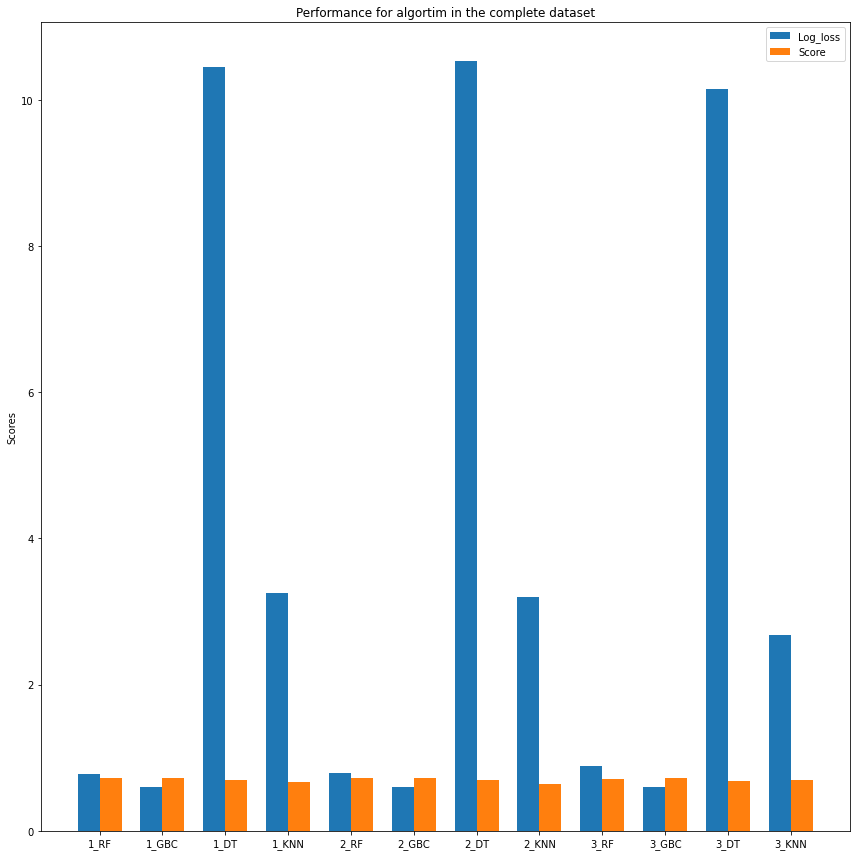

In [ ]:
# Complete dataset
plt.rcParams['figure.figsize'] = [12,12]
labels = Scores_consolidado_completo.columns
log_loss = log_loss_complete
score = scores_complete

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, log_loss, width, label='Log_loss')
rects2 = ax.bar(x + width/2, score, width, label='Score')


ax.set_ylabel('Scores')
ax.set_title('Performance for algortim in the complete dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()


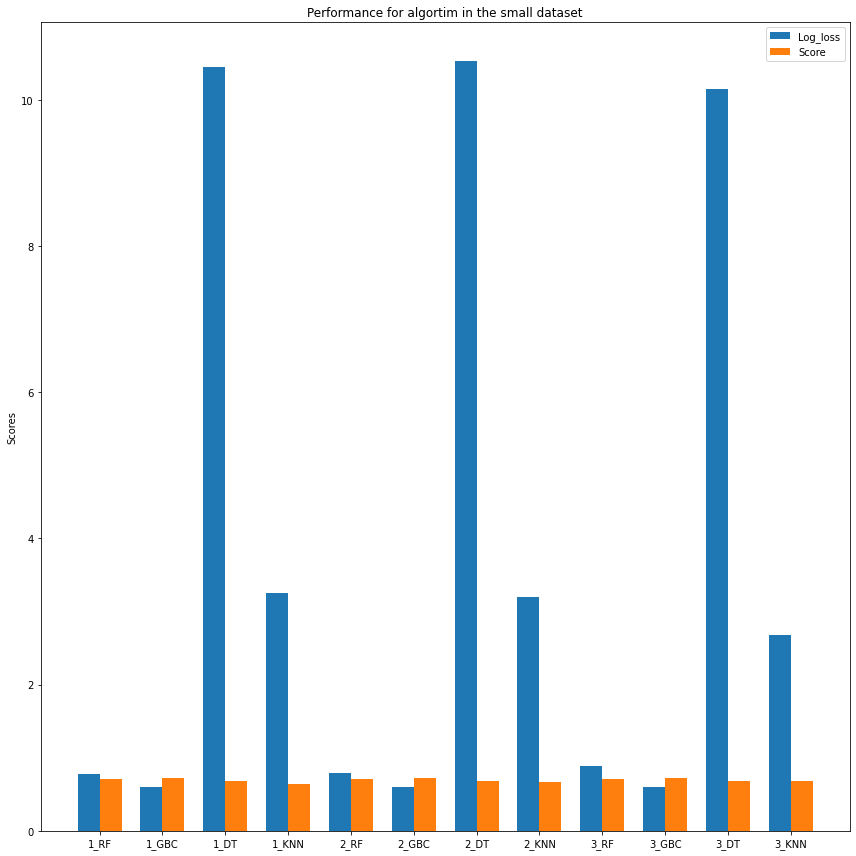

In [ ]:
# small dataset
plt.rcParams['figure.figsize'] = [12,12]

labels = Scores_consolidado.columns
log_loss = log_loss
score = scores

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, log_loss, width, label='Log_loss')
rects2 = ax.bar(x + width/2, score, width, label='Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance for algortim in the small dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

In [ ]:
log_loss.idxmin(), scores.idxmax() 

('3_GBC', '3_GBC')

In [ ]:
log_loss_complete.idxmin(), scores_complete.idxmax() 

('3_GBC', '2_RF')

In [ ]:
scores_complete - scores

1_RF     0.013995
1_GBC    0.001354
1_DT     0.014447
1_KNN    0.028442
2_RF     0.016704
2_GBC    0.001806
2_DT     0.009932
2_KNN   -0.028442
3_RF     0.003612
3_GBC    0.000903
3_DT     0.004063
3_KNN    0.022122
dtype: float64

Conclusion: Para ambos datasets el algoritmo que tuve mejor rendimiento en la metrica 'Log_loss' fue el 3_GBC que es un Gradiente Bossting Classifier con los datos escalados y la seleccion automatica de features, sin embargo este algortimo tuvo un mejor desempeño en la metrica accuracy con el dataset 1. Con estas condiciones se procedera a realizar una optimizacion de hiperparametros

In [ ]:
Scores_consolidado_completo.to_csv('scores_consolidado_completo.csv', index = False)
Scores_consolidado.to_csv('score_consolidado.csv', index = False)

# Generando Submission

In [ ]:
X_selected = selector.transform(X) 
X_selected = StandardScaler().fit_transform(X_selected)
X_selected.shape

(7381, 64)

In [ ]:
gb = GradientBoostingClassifier()

In [ ]:
gb.fit(X_selected, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
X_submision = selector.transform(test)
X_submision = StandardScaler().fit_transform(X_submision)
y_submision =  gb.predict_proba(X_submision)

In [ ]:
test = pd.read_csv('test_consolidado.csv')
pred_df=pd.DataFrame(y_submision,columns=['predict_0', 'predict_1', 'predict_2'])
submission=pd.concat([test[['id']],pred_df],axis=1)
submission.to_csv('submission_1.csv',index=False,header=True)